In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from analyzer.model.regression_model import RegressionModel
from data.io import Reader, Saver
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Загружаем данные
df = Reader.read_csv('./dataset/df_lowcost.csv')

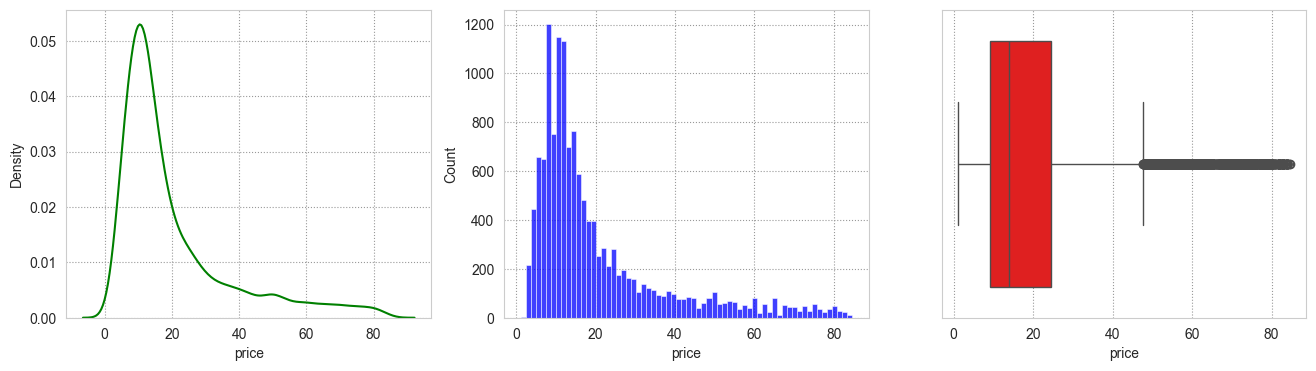

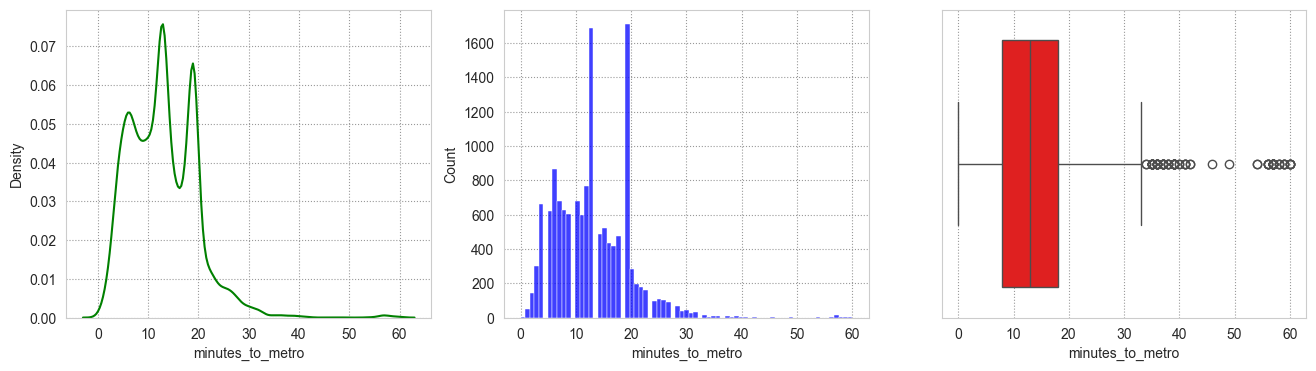

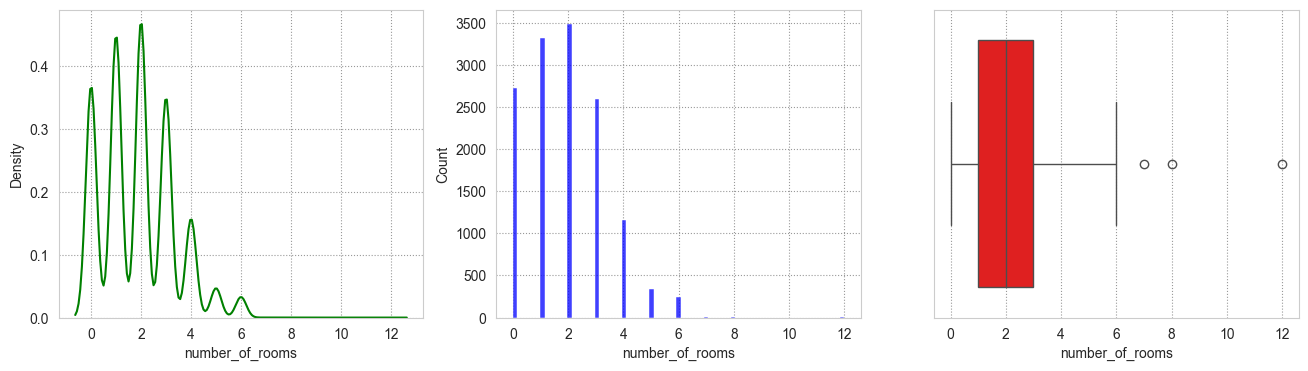

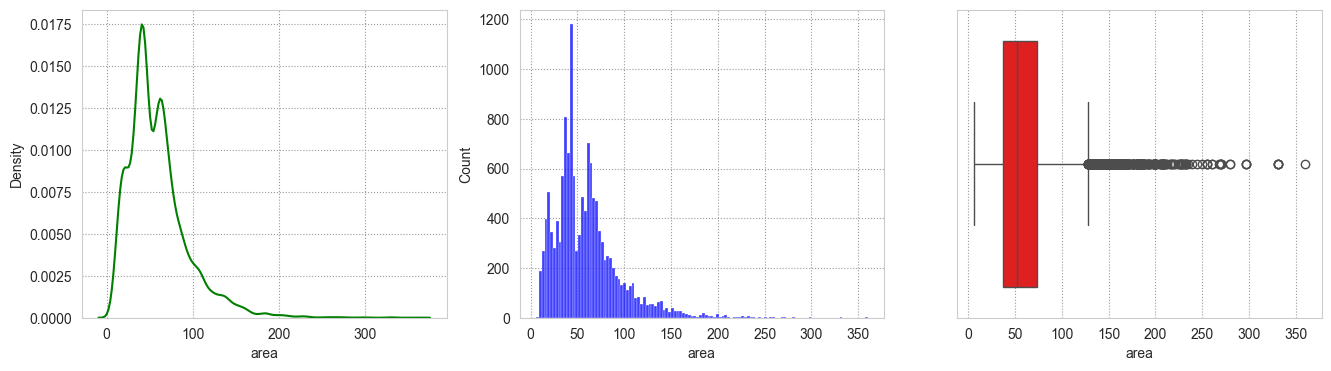

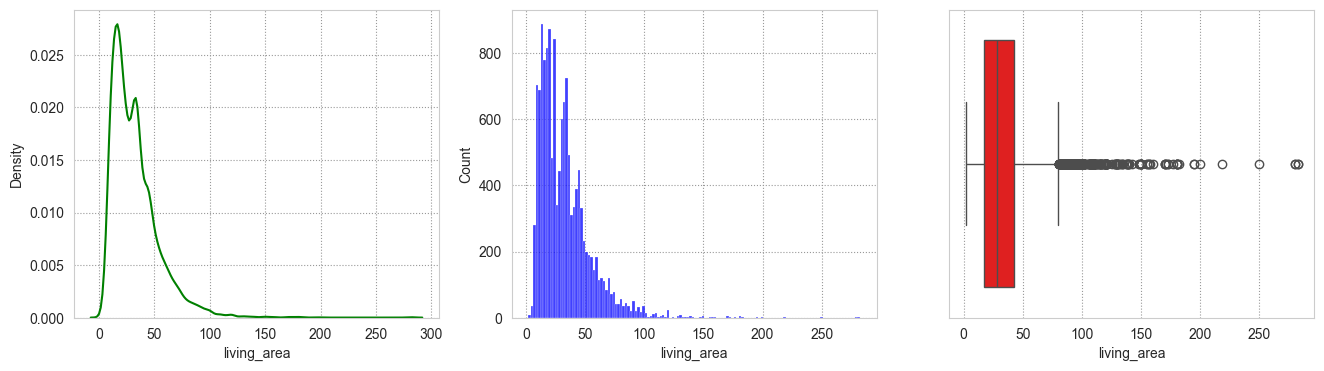

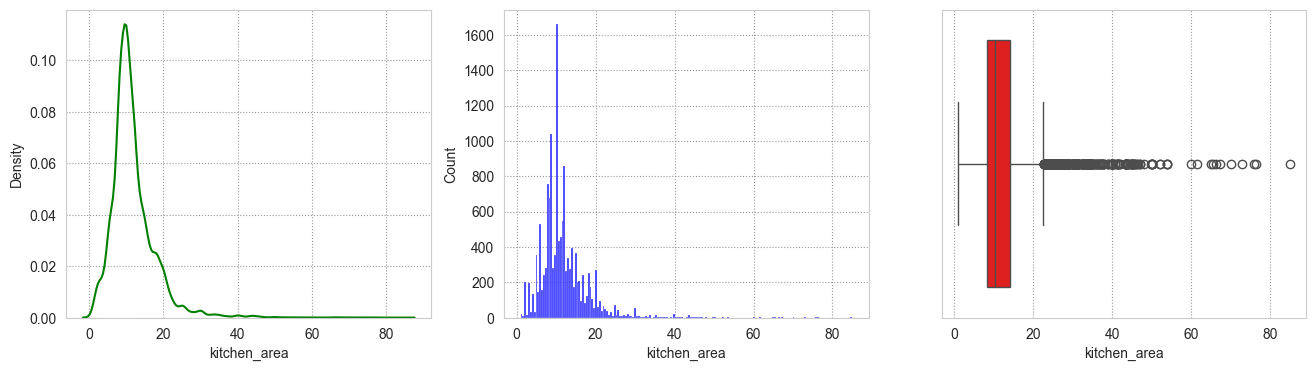

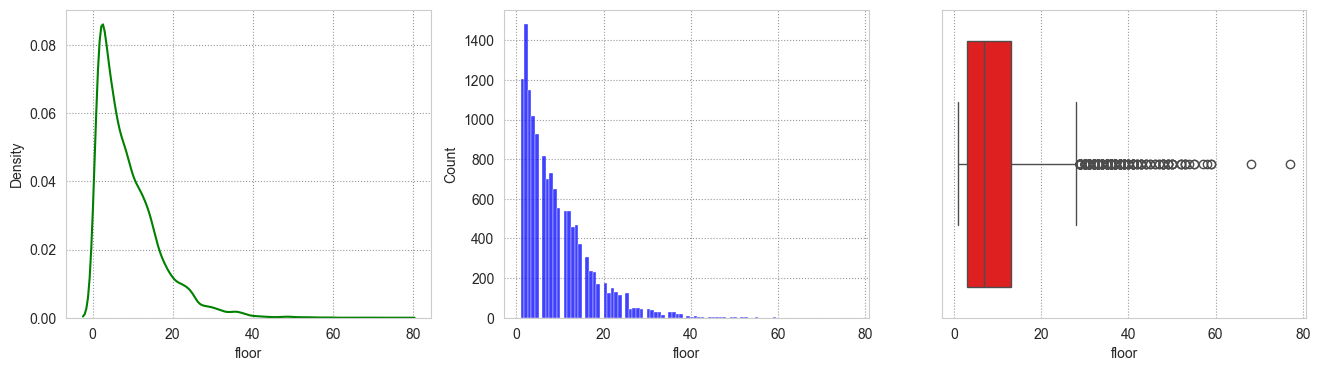

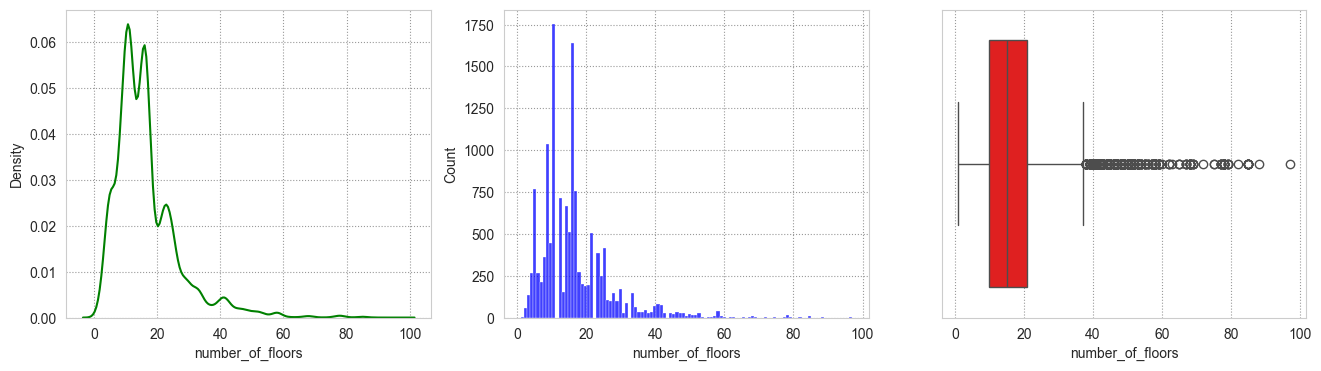

In [3]:
# ещё раз визуально оцениваем обычную недвижимость
Drawer.plot_numeric_seaborn(df)

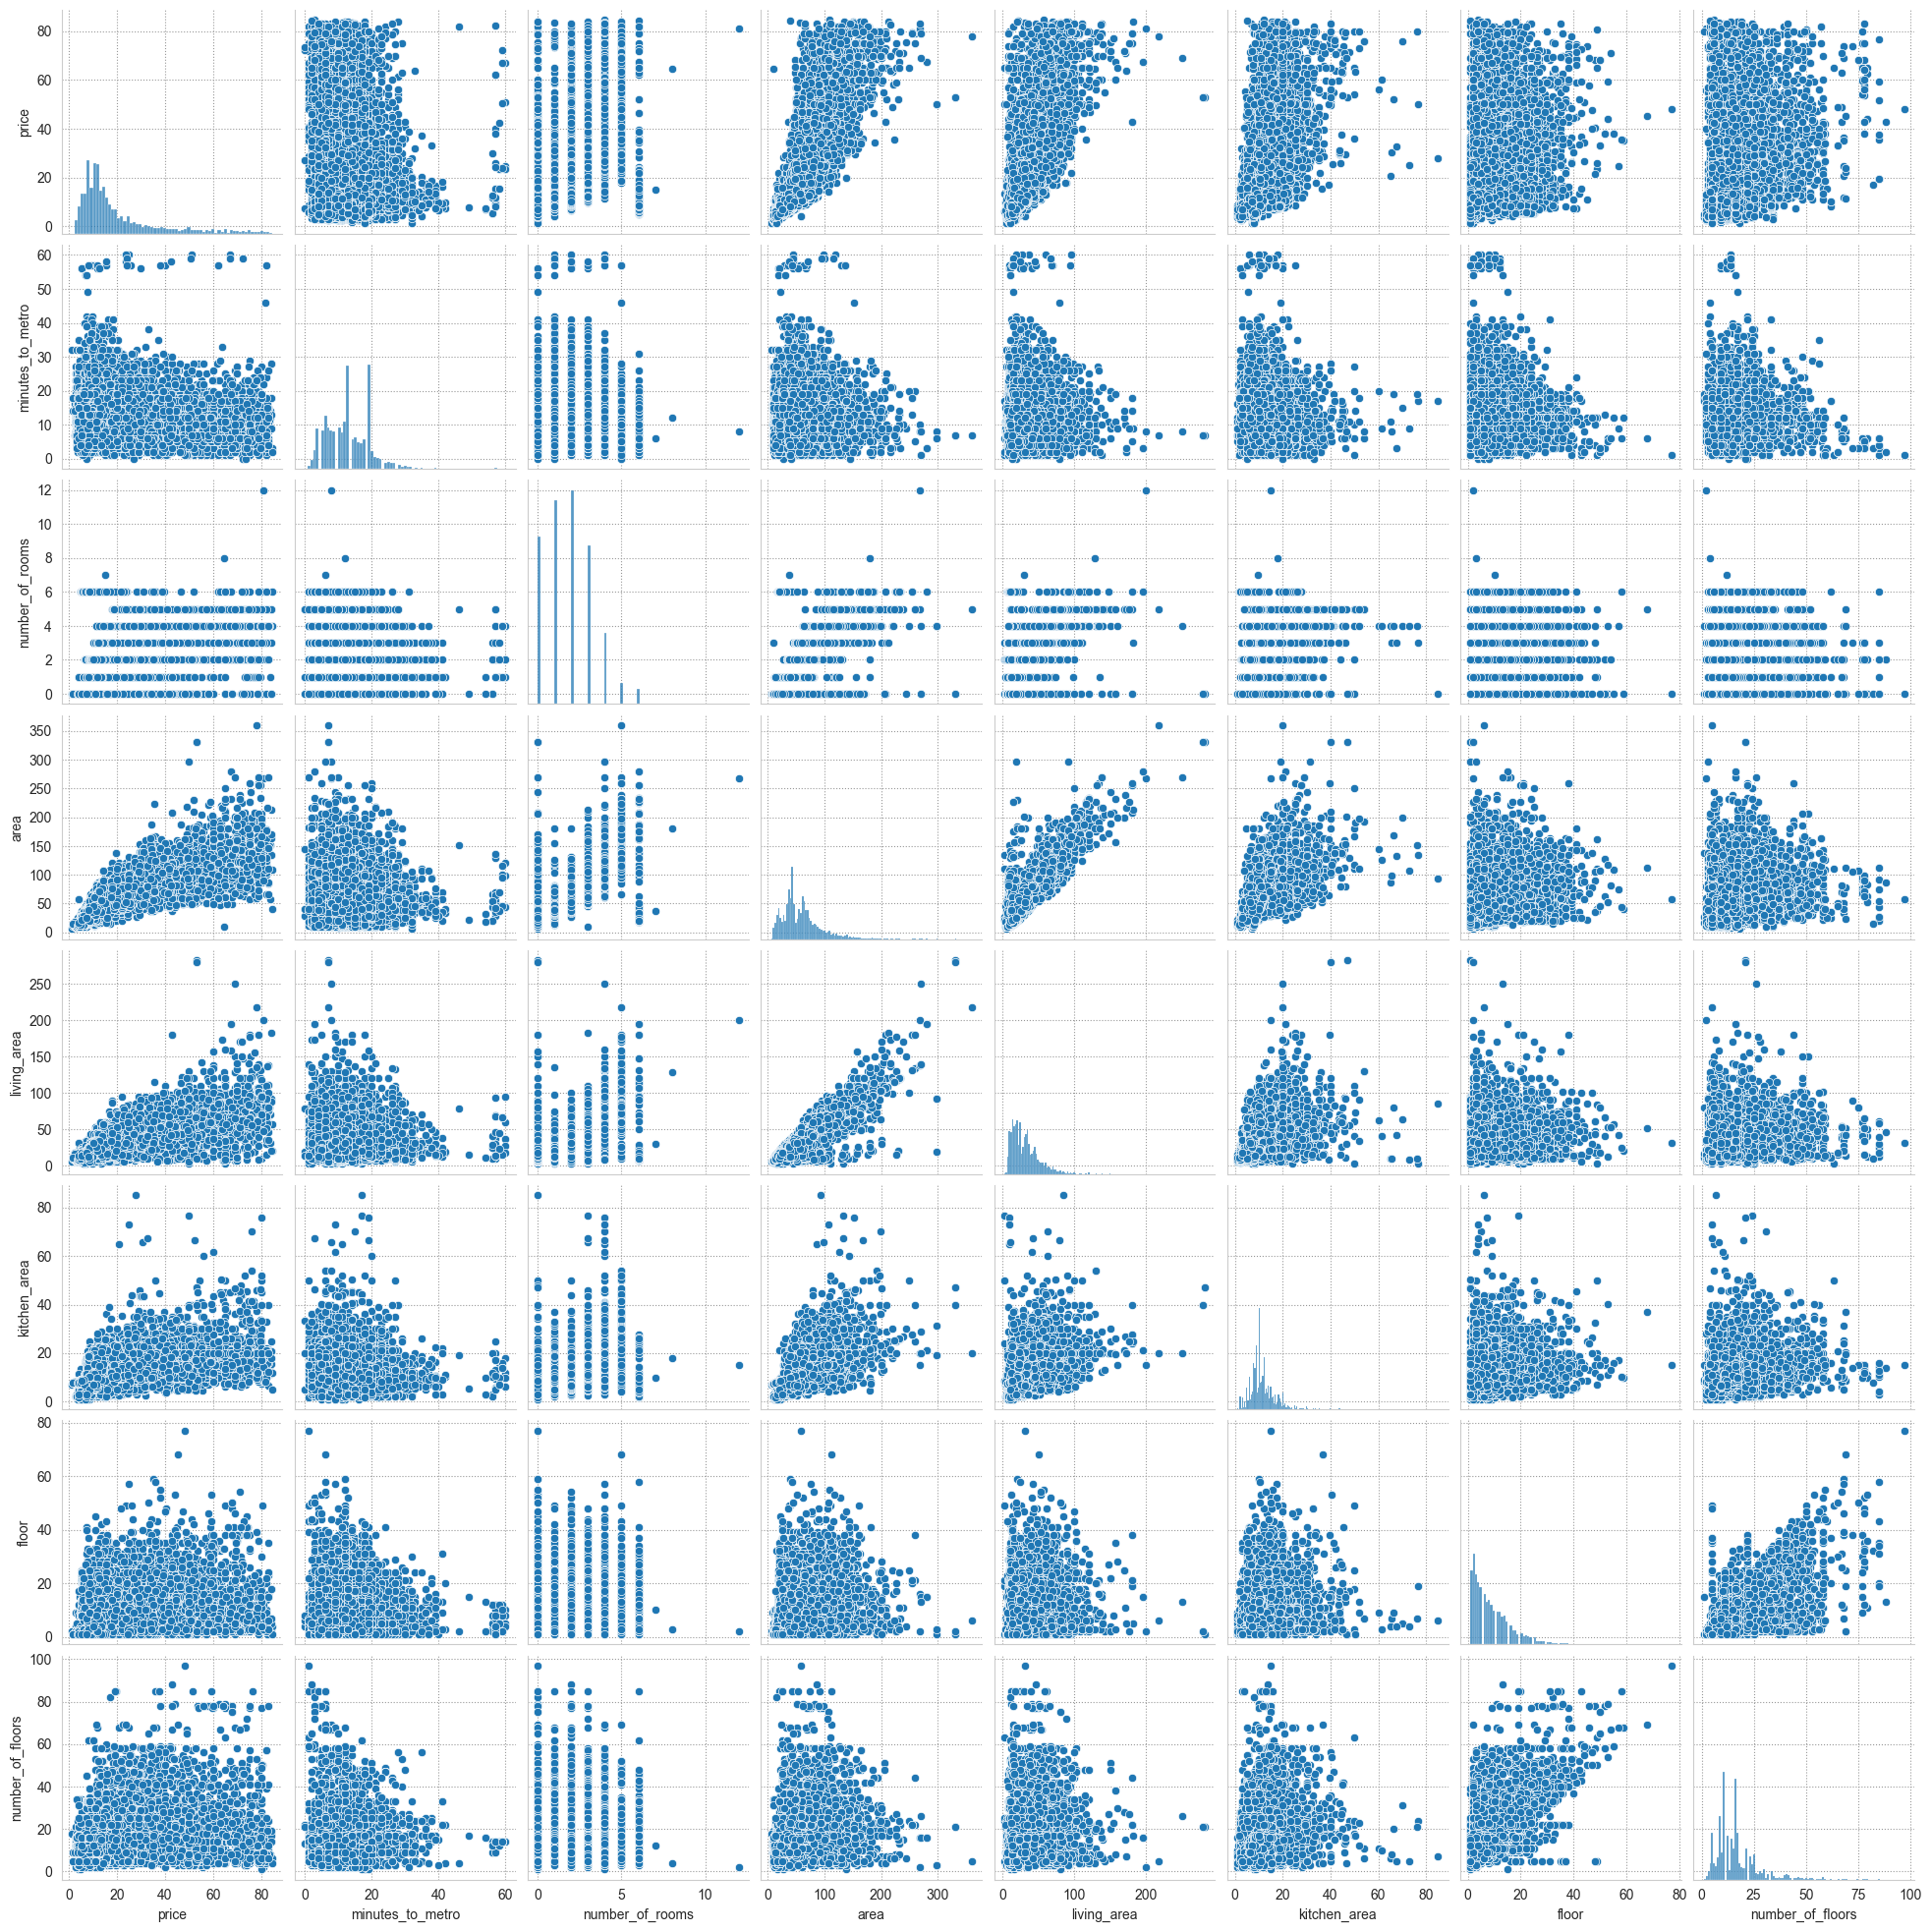

In [4]:
# Исследуем графически зависимость признаков на целевую переменную недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

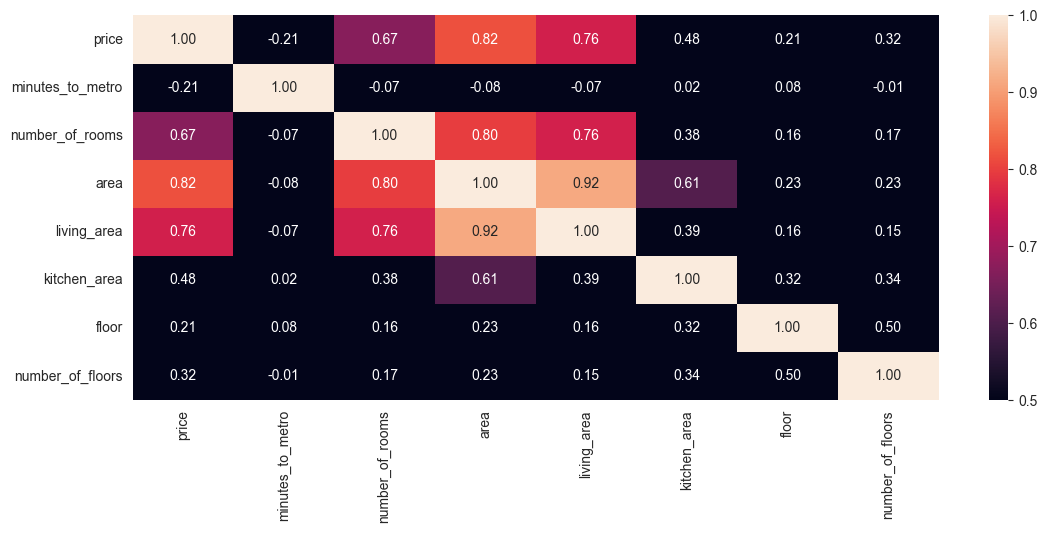

In [5]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', vmin=0.5)
plt.show()

Выводы:
1. графически наблюдается связь цены квартиры от площади.
2. наблюдается корреляция признаков: площадь (area) коррелирует с жилой площадью (living_area) и с площадью кухни (kitchen_area), также числом комнат (number_of_rooms), что избыточно и в дальнейшем можно удалить эти колонки при обнаружении между ними сильной VIF.

In [6]:
# Проверим допущение о мультиколлинеарности
numeric_col = df.drop(columns='price').describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.962052
number_of_rooms,5.330253
area,40.328189
living_area,23.031125
kitchen_area,8.434223
floor,3.557501
number_of_floors,4.906106


In [7]:
# Проверим допущение о мультиколлинеарности ещё раз
numeric_col = df.drop(columns=['price', 'living_area', 'kitchen_area', 'number_of_rooms']).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
minutes_to_metro,2.670982
area,3.196631
floor,3.532578
number_of_floors,4.702908


Вывод: для обычной недвижимости четыре признака оказались менее 5, то есть с этими признаками можно работать

In [8]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

,apartment_type,metro_station,renovation
count,13873,13873,13873
unique,2,531,4
top,Secondary,Депо,Cosmetic
freq,10260,1646,6439


Выводы:
1. у нас всего 2 типа аппартаментов в датасете
2. у нас всего 4 вида ремонта в датасете
3. станций метро в москве слишком много (вся россия работает на благоустройство москвы)

In [9]:
column_list = ['apartment_type']

for column in column_list:
    groups = []
    for unique_value in df[column].unique():
        groups.append(df[df[column] == unique_value]['price'])
    StatCriteria().mannwhitneyu(groups)

Mann-Whitney U test
U_statistic = 27560809.500
Распределения двух выборок не равны (p-value = 0.000).


In [10]:
column_list = ['metro_station', 'renovation']

for column in column_list:
    groups = []
    for unique_value in df[column].unique():
        groups.append(df[df[column] == unique_value]['price'])
    StatCriteria().kruskal(groups)

kruskal
statistic = 7629.413
Медианы всех групп не равны (p-value = 0.000).
kruskal
statistic = 3241.754
Медианы всех групп не равны (p-value = 0.000).


Вывод: на стоимость lowcost недвижимости влияют все категориальные переменные такие как:
1. apartment_type,
2. metro_station,
3. renovation

поэтому их все придётся учитывать при проведении регрессии.

In [11]:
df['apartment_type'] = Encoder().booleanOneColumnEncoder(df['apartment_type'], 'Secondary')
df['renovation'] = Encoder().labelEncoder(df['renovation'])

In [12]:
# проверяем датасет
df.head(5)

,price,apartment_type,metro_station,minutes_to_metro,number_of_rooms,area,living_area,kitchen_area,floor,number_of_floors,renovation
0,10.200000,1,Тургеневская,4,0,19.10,17.1,2.0,1,8,2
1,8.816000,0,Депо,19,1,44.08,24.4,10.3,15,11,0
2,29.700000,1,Новаторская,16,3,77.90,45.6,10.2,2,22,2
3,18.700000,1,Бибирево,24,3,72.00,43.4,10.4,8,17,2
4,7.420587,1,Бунинская аллея,5,6,24.00,9.1,5.7,14,19,0


In [13]:
# подготавливаем данные
exclude_features = ['price', 'apartment_type', 'living_area', 'kitchen_area', 'number_of_rooms']
target = ['price']
X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

columns_for_encoding = ['metro_station']
X_train, X_test, _ = Encoder().leaveOneOutEncoder(X_train, X_test, y_train, columns_for_encoding)

# проводим нормализацию (логарифмирование)
X_train, X_test, y_train, y_test = Normalizer().log1p_norm(X_train, X_test, y_train, y_test)
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

In [14]:
# Применяем готовую линейную регрессию из библиотеки statsmodels
y_test, y_pred, _ = RegressionModel().OLS(X_train, X_test, y_train, y_test, prepend=False)
residuals = y_test - y_pred

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 1.442e+04
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        03:57:05   Log-Likelihood:                 819.85
No. Observations:               10404   AIC:                            -1626.
Df Residuals:                   10397   BIC:                            -1575.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
metro_station        1.4843      0.015  

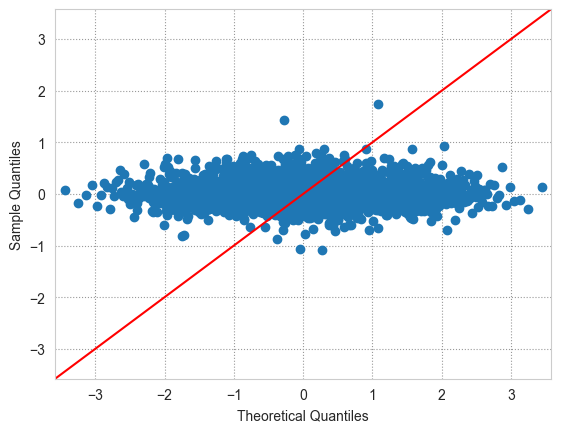

In [15]:
# Проверка на нормальность остатков
fig = sm.qqplot(residuals, line='45')
plt.show()

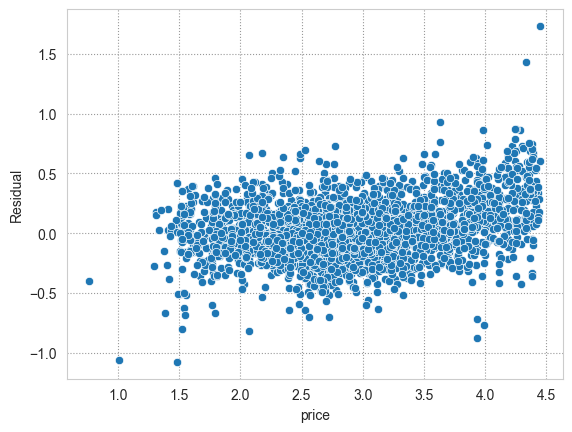

In [16]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()

In [17]:
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test, alpha=0.01)
residuals = y_test - y_pred

R²: 0.881
MAE: 0.18
MAPE: 7%
RMSE: 0
MSE: 0
__________
Коэффициенты Lasso-регрессии:
metro_station: 1.32
minutes_to_metro: -0.00
area: 2.52
floor: 0.00
number_of_floors: 0.00
renovation: 0.19


Выводы: не влияют minutes_to_metro, floor, number_of_floor